<h2> CNN with 1 Convolutional Layer - Validation Set to Reduce Overfitting </h2>

<p>https://stats.stackexchange.com/questions/283631/how-to-correctly-use-validation-and-test-sets-for-neural-network-training</p>

In [0]:
import glob
import math
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn.metrics as metrics

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import add, concatenate, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Activation, AveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/'  #change dir to your project folder

In [4]:
trDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-imgs224-0.8.npz')['arr_0']
trLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-train-labels224-0.8.npz')['arr_0']
tsDatOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-imgs224-0.8.npz')['arr_0']
tsLblOrg       = np.load(root_path + 'Flower_Power/flrnonflr-test-labels224-0.8.npz')['arr_0']

print("For the training and test datasets:")
print("The shapes are %s, %s, %s, %s" \
      %(trDatOrg.shape, trLblOrg.shape, tsDatOrg.shape, tsLblOrg.shape))

For the training and test datasets:
The shapes are (4264, 224, 224, 3), (4264,), (1067, 224, 224, 3), (1067,)


In [5]:
# Randomly show 10 examples of the images

data = tsDatOrg
label = tsLblOrg

for i in range(20):
    index = random.randint(0, len(data)-1)
    print("Showing %s index image, It is %s" %(index, label[index]))
    imgplot = plt.imshow(data[index])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# Convert the data into 'float32'
# Rescale the values from 0~255 to 0~1
trDat       = trDatOrg.astype('float32')/255
tsDat       = tsDatOrg.astype('float32')/255

# Retrieve the row size of each image
# Retrieve the column size of each image
imgrows     = trDat.shape[1]
imgclms     = trDat.shape[2]
channel     = 3

# Perform one hot encoding on the labels
# Retrieve the number of classes in this problem
trLbl       = to_categorical(trLblOrg)
tsLbl       = to_categorical(tsLblOrg)
num_classes = tsLbl.shape[1]

In [0]:
# Split original training data to sub-training (80%) and validation data (20%)
X_train, X_val, y_train, y_val = train_test_split(trDat, trLbl, test_size=0.2, random_state=13)

In [0]:
# X_test forms the test images, and y_test forms the test labels
X_test = tsDat 
y_test = tsLbl 


<h2> Define Model </h2>

<p>The 1st layer is a Conv2D layer for the convolution operation that extracts features from the input images by sliding a convolution filter over the input to produce a feature map. Here I choose feature map with size 3 x 3.
  
The 2nd layer is a MaxPooling2D layer for the max-pooling operation that reduces the dimensionality of each feature, which helps shorten training time and reduce number of parameters. Here I choose the pooling window with size 2 x 2.
  
The next step is to feed the last output tensor into a stack of Dense layers, otherwise known as fully-connected layers. These densely connected classifiers process vectors, which are 1D, whereas the current output is a 3D tensor. Thus, I need to flatten the 3D outputs to 1D, and then add 2 Dense layers on top.
  
I do a 2-way classification (as there are flowers and non-flowers), using a final layer with 2 outputs and a softmax activation. Softmax activation enables me to calculate the output based on the probabilities. Each class is assigned a probability and the class with the maximum probability is the model’s output for the input. <p>

In [9]:
# fix random seed for reproducibility
seed = 29
np.random.seed(seed)

modelname = 'FlowerPower_Base'

def createBaseModel():
  inputs = Input(shape=(imgrows, imgclms, channel))
  x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  
  x = Flatten()(x)
  
  x = Dense(128, activation='relu')(x)
  x = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs=[inputs],outputs=x)
  
  model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])
  
  return model
  
model = createBaseModel()
modelGo = createBaseModel()

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               51380352  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total par

<h2> Training the Model </h2>

<p>I train the model with batch size of 64 and 20 epochs on both training and validation data. </p>

In [10]:
# Fit the model
# This is where the training starts
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_data=(X_val, y_val))

Train on 3411 samples, validate on 853 samples
Epoch 1/20
3411/3411 [==============================] - 11s 3ms/sample - loss: 5.5702 - acc: 0.5969 - val_loss: 0.5790 - val_acc: 0.7175
Epoch 2/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.5193 - acc: 0.7608 - val_loss: 0.4806 - val_acc: 0.7948
Epoch 3/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.3381 - acc: 0.8660 - val_loss: 0.4554 - val_acc: 0.7995
Epoch 4/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.1650 - acc: 0.9452 - val_loss: 0.4644 - val_acc: 0.8218
Epoch 5/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.0660 - acc: 0.9848 - val_loss: 0.4070 - val_acc: 0.8370
Epoch 6/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.0296 - acc: 0.9944 - val_loss: 0.6325 - val_acc: 0.8159
Epoch 7/20
3411/3411 [==============================] - 7s 2ms/sample - loss: 0.0201 - acc: 0.9977 - val_loss: 0.5499 - val_acc: 0.8335


In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8618111646722831
Test accuracy: 0.8444236


<h2> Data Augmentation </h2>

This section tests the usefulness of data augmentation in reducing overfitting. 

Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, the model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the ImageDataGenerator instance.

1. rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
2. width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.
3. shear_range is for randomly applying shearing transformations.
4. zoom_range is for randomly zooming inside pictures.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

Using TensorFlow backend.


In [13]:
history1 = model.fit_generator(batches, steps_per_epoch=3411//64, epochs=20,
                    validation_data=val_batches, validation_steps=853//64, use_multiprocessing=True)

Epoch 1/20
53/53 [==============================] - 53s 1s/step - loss: 0.4708 - acc: 0.8010 - val_loss: 0.4629 - val_acc: 0.8173
Epoch 2/20
53/53 [==============================] - 53s 1s/step - loss: 0.3505 - acc: 0.8544 - val_loss: 0.4094 - val_acc: 0.8149
Epoch 3/20
53/53 [==============================] - 53s 995ms/step - loss: 0.3206 - acc: 0.8652 - val_loss: 0.3928 - val_acc: 0.8233
Epoch 4/20
53/53 [==============================] - 53s 995ms/step - loss: 0.3018 - acc: 0.8724 - val_loss: 0.4101 - val_acc: 0.8281
Epoch 5/20
53/53 [==============================] - 53s 996ms/step - loss: 0.2871 - acc: 0.8775 - val_loss: 0.3753 - val_acc: 0.8438
Epoch 6/20
53/53 [==============================] - 53s 994ms/step - loss: 0.2661 - acc: 0.8865 - val_loss: 0.3380 - val_acc: 0.8534
Epoch 7/20
53/53 [==============================] - 52s 977ms/step - loss: 0.2751 - acc: 0.8913 - val_loss: 0.3796 - val_acc: 0.8450
Epoch 8/20
53/53 [==============================] - 52s 986ms/step - loss: 

In [14]:
score1 = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.5098997400314202
Test accuracy: 0.86035615


<h2> Results </h2>

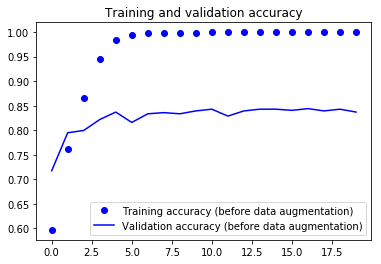

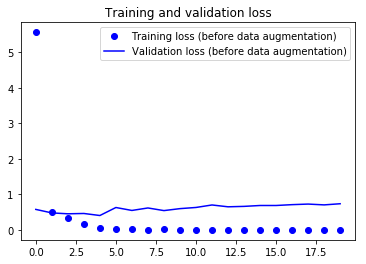

In [15]:
#plot graphs to interpret the results (before data augmentation)

accuracy_org = history.history['acc']
val_accuracy_org = history.history['val_acc']
loss_org = history.history['loss']
val_loss_org = history.history['val_loss']
epochs_org = range(len(accuracy_org))

plt.plot(epochs_org, accuracy_org, 'bo', label='Training accuracy (before data augmentation)')
plt.plot(epochs_org, val_accuracy_org, 'b', label='Validation accuracy (before data augmentation)')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs_org, loss_org, 'bo', label='Training loss (before data augmentation)')
plt.plot(epochs_org, val_loss_org, 'b', label='Validation loss (before data augmentation)')
plt.title('Training and validation loss')
plt.legend()
plt.show()

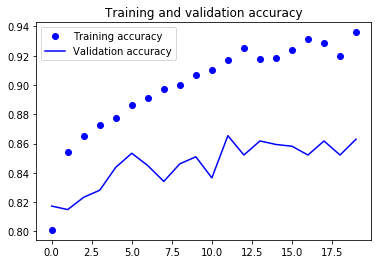

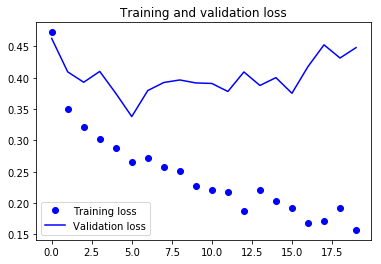

In [16]:
#plot graphs to interpret the results (after data augmentation)

accuracy = history1.history['acc']
val_accuracy = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<p> Data Augumentation reduces overfitting </p>

<h2> Classification Results </h2>

In [17]:
# Make classification on the test dataset
predicts    = model.predict(X_test)

# Prepare the classification output
# for the classification report
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

# the labels for the classfication report
labelname   = ['flower', 'non-flower']


testScores  = metrics.accuracy_score(testout,predout)
confusion   = metrics.confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,predout,target_names=labelname,digits=4))
print(confusion)

Best accuracy (on testing dataset): 86.04%
              precision    recall  f1-score   support

      flower     0.8961    0.7599    0.8224       454
  non-flower     0.8402    0.9347    0.8849       613

    accuracy                         0.8604      1067
   macro avg     0.8681    0.8473    0.8537      1067
weighted avg     0.8640    0.8604    0.8583      1067

[[345 109]
 [ 40 573]]


To combat overfititng, I add a Dropout layer as the 3rd layer, a powerful regularization technique. Dropout is the method used to reduce overfitting. It forces the model to learn multiple independent representations of the same data by randomly disabling neurons in the learning phase. In this model, dropout will randomnly disable 20% of the neurons.

<p> Dropout is a regularization technique, and is most effective at preventing overfitting. <b> However, there are several places when dropout can hurt performance.</b>
 
1.   Right before the last layer. This is generally a bad place to apply dropout, because the network has no ability to "correct" errors induced by dropout before the classification happens. <br>
  
2.   When the network is small relative to the dataset, regularization is usually unnecessary. If the model capacity is already low, lowering it further by adding regularization will hurt performance. I noticed most of your networks were relatively small and shallow. <br>
  
3.  When training time is limited.Usually dropout hurts performance at the start of training, but results in the final ''converged'' error being lower. Therefore, if we don't plan to train until convergence, you may not want to use dropout.  </p>